## Import and define functions

In [2]:
import torch
import os
from VAE_untd_1_3 import BetaVAE
import pandas as pd
import sklearn
import glob, random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import seaborn as sn
import random
import math
import pickle
from torch.autograd import Variable

from torch import nn
from torch.nn import functional as F

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim import SGD, AdamW, Adagrad  # Supported Optimizers
from torch.utils.data import DataLoader

from multiprocessing import cpu_count
from numpy.random import randint

import MLmodels_untd as m

from math import floor

# pathways to data files
#trained_model_pw = "r_b3_c2/tb_logs/BVAE_trial/version_0/checkpoints/epoch=199-step=10599.ckpt"
#trained_model_pw = "r_np1_c2/tb_logs/BVAE_trial/version_0/checkpoints/epoch=199-step=18199.ckpt"
trained_model_pw = "r_np3_c2/tb_logs/BVAE_trial/version_0/checkpoints/epoch=199-step=10599.ckpt"
ds_b3_c2 = "./peptide/b3_c2.fasta"
ds_np1_c2 = "./peptide/np1_c2.fasta"
ds_np2_c2 = "./peptide/np2_c2.fasta"
ds_np3_c2 = "./peptide/np3_c2.fasta"

#Configuration
con = {"chem_type": "pept", #pept or dna
              "datatype": None, #if  chem_type is pept, fill in None (dna data analysed before were "HCB20")
              "in_channels": 1,
              "latent_dim": 50,
              "beta": 5,  # # only used if loss_type == "H", beta = 1 is standard VAE
              "gamma": 1,  # only used if loss_type == "B"
              "hidden_dims": [8, 16, 32, 64, 512],
              "max_capacity": 25,  # only used if loss_type == "B"
              "capacity_max_iter": 1e5,  # only used if loss_type == "B"
              "loss_type": "H",  # B or Htitle=Non
              "data_worker_num": 6,
              "optimizer": "AdamW",
              "lr": 1e-3,
              "seed": randint(0, 100000, 1)[0],
              "batch_size": 1000,
              "replicas": 4,  # Number of samples for validation step
              "epochs": 200,
              "attention_layers": False, # This doesn't quite work yet
              "data_file": ds_b3_c2  
              }


/home/aneta/anaconda3/envs/buba/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [3]:
def predict_vae_beta(dataloader, rd): #used for random data and other datasets
    xpss = []
    inputss = []
    n=0
    for i, batch in enumerate(dataloader): #used for loading validation and trianing data
        n=n+1
        seqs, ohe, labels = batch
        seq_aves = []
        pred_aves = []
        replicas = 2
        for _ in range(replicas):
            recon_x, inputs, mu, log_var, encode_attn_maps, decode_attn_maps = model(ohe)
            seq_aves.append(recon_x)
        xp = torch.mean(torch.stack(seq_aves, dim=0), dim=0)
        
        rd_result = get_results(xp,inputs)
    
        torch.save(rd_result,'results%s_%i.pt'%(rd,i))
    return n

def predict_vae_beta2(dataloader, rd):
    xpss = []
    inputss = []
    n=0
    for i, batch in enumerate(dataloader):
        n=n+1
        seqs, ohe = batch
        seq_aves = []
        pred_aves = []
        replicas = 2
        for _ in range(replicas):
            recon_x, inputs, mu, log_var, encode_attn_maps, decode_attn_maps = model(ohe)
            seq_aves.append(recon_x)
        xp = torch.mean(torch.stack(seq_aves, dim=0), dim=0)
        
        rd_result = get_results(xp,inputs)
    
        torch.save(rd_result,'results%s_%i.pt'%(rd,i))
    return n

def load_back_tensors(n,tensor_file,td_vd):
    tnsr_all = []
    for k in range(0,n):
        tnsr = torch.load(tensor_file%(td_vd,k))
        tnsr_all += tnsr
        os.remove(tensor_file%(td_vd,k)) 
    return(tnsr_all)  

#Function to create the Data loader
def create_dataloader(random_set):
    # Load data into dictionaries so we can make them pandas dataframes
    randict = {'sequence':list(random_set.keys()), 'binary':list(random_set.values())}
    # Load dictionarie into pandas dataframe
    _randdict = pd.DataFrame(randict)
    #Make pytorch reader (same is done for training and verification data in each model)
    rand_reader = m.AAReader(_randdict,shuffle=False) #change for DNA
    # Make Data loader
    rand_loader = torch.utils.data.DataLoader(
        rand_reader,
        batch_size=500, #1000
        collate_fn=m.my_collate,
        shuffle=False)
    return(rand_loader)


#Code from helper_tools.py
#Compute log probability of a particular mutant sequence from a pwm and a one-hot encoding
def compute_log_probability(one_hot_seq,pwm):
    prod_mat=np.matmul(one_hot_seq.T,pwm)
    #print(prod_mat)
    #log_prod_mat=np.log(prod_mat)
    sum_diag=np.trace(prod_mat)
    log_sum_diag=np.log(sum_diag)
    return log_sum_diag

def get_results(xps,inps):
    lst = []        
    for i in range(len(xps)):
        log_prob = compute_log_probability(inps[i][0].numpy(),xps[i][0].detach().numpy())
        lst.append(log_prob)
    return lst

In [ ]:
#load model
model = BetaVAE(con, debug=False)

checkpoint = torch.load(trained_model_pw,map_location=torch.device('cpu')) 
model.load_state_dict(checkpoint['state_dict'])  # load checkpoint file
model.prepare_data() 

## Run functions to get results

In [ ]:
#get random sequence of peptides
#Function to create random x position sequence 
def create_random_set(set_size, seq_size):
    random.seed(24)
    random_set = {}
    for _ in range(set_size):
        sequence = ''.join(random.choice("ARNDCEQGHILKMFPSTWYV-") for _ in range(seq_size))
        random_set[sequence]=0
    return random_set

ran_s = create_random_set(50000,45)

rd = create_dataloader(ran_s)
n_r = predict_vae_beta(rd,"rd")
results_r = load_back_tensors(n_r,'results%s_%i.pt',"rd")

with open("random_backup_trained_np3_n", "wb") as fp:   #Pickling
    pickle.dump(results_r, fp)

In [ ]:
#RESULTS for NP1
seqs = m.fasta_read_pep(ds_np1_c2)
seq_, c = np.unique(seqs, return_counts=True, axis=0)
c_dict = dict(zip(seq_, c))
count_ = [c_dict[s] for s in seq_]
data = pd.DataFrame({'sequence': seq_, 'affinity': count_})
dict_np1 = {}
for i in range(len(data)):
    dict_np1[data.sequence[i]] = data.affinity[i]

np1_d = create_dataloader(dict_np1)
n_np1 = predict_vae_beta(np1_d,"np1_d")
results_np1 = load_back_tensors(n_np1,'results%s_%i.pt',"np1_d")

with open("np1_backup_trained_np3_n", "wb") as fp:   #Pickling
    pickle.dump(results_np1, fp)

In [ ]:
#RESULTS for B3
seqs = m.fasta_read_pep(ds_b3_c2)
seq_, c = np.unique(seqs, return_counts=True, axis=0)
c_dict = dict(zip(seq_, c))
count_ = [c_dict[s] for s in seq_]
data = pd.DataFrame({'sequence': seq_, 'affinity': count_})
dictb3 = {}
for i in range(len(data)):
    dictb3[data.sequence[i]] = data.affinity[i]

b3_d = create_dataloader(dictb3)
n_b3 = predict_vae_beta(b3_d,"b3_d")
results_b3 = load_back_tensors(n_b3,'results%s_%i.pt',"b3_d")

with open("b3_backup_trained_np3_n", "wb") as fp:   #Pickling
    pickle.dump(results_b3, fp)

In [ ]:
vd = model.val_dataloader()
n_v = predict_vae_beta2(vd,"vd")
results_v = load_back_tensors(n_v,'results%s_%i.pt',"vd")

td = model.train_dataloader()
n_t = predict_vae_beta2(td,"td")
results_t = load_back_tensors(n_t,'results%s_%i.pt',"td")

with open("t_backup_trained_np3_n", "wb") as fp:   #Pickling
    pickle.dump(results_t, fp)
with open("v_backup_trained_np3_n", "wb") as fp:   #Pickling
    pickle.dump(results_v, fp)

## Load previous session results

In [5]:
#Unpickling
with open("random_backup_trained_np3_n", "rb") as fp:
   results_r = pickle.load(fp)
with open("np1_backup_trained_np3_n", 'rb') as fp:
    results_np1 = pickle.load(fp)
with open("b3_backup_trained_np3_n", "rb") as fp: 
    results_b3 = pickle.load(fp)
with open("t_backup_trained_np3_n", "rb") as fp: 
    results_t = pickle.load(fp)
with open("v_backup_trained_np3_n", "rb") as fp: 
    results_v = pickle.load(fp)

## Graphs

In [6]:
def normalisation_hist(seqs_likelihoods):
    myarray = np.asarray(seqs_likelihoods)
    weights = np.ones_like(myarray)/float(len(myarray))
    return weights

weights_rd = normalisation_hist(results_r)
#weights_np3 = normalisation_hist(results_np3)
weights_np1 = normalisation_hist(results_np1)
weights_b3 = normalisation_hist(results_b3)
weights_t = normalisation_hist(results_t)
weights_v = normalisation_hist(results_v)

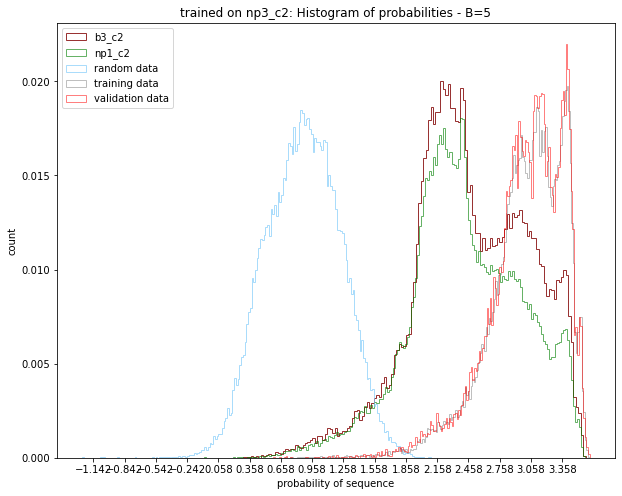

In [136]:
plt.figure(figsize=(10,8))
plt.hist(results_b3,alpha=0.8,bins=200,label="b3_c2", weights = weights_b3, color = "maroon", histtype='step');
plt.hist(results_np1,alpha=0.6,bins=200,label="np1_c2", weights = weights_np1, color = "green", histtype='step');
#plt.hist(results_np3,alpha=0.5,bins=200,label="np3_c2", weights = weights_np3, color = "darkorange", histtype='step');
plt.hist(results_r,alpha=0.7,bins=200,label="random data", weights = weights_rd, color="lightskyblue", histtype='step');
plt.hist(results_t,alpha=0.5,bins=200,label="training data", weights = weights_t, color="grey", histtype='step');
plt.hist(results_v,alpha=0.5,bins=200,label="validation data", weights = weights_v, color="red", histtype='step');

plt.xlabel("probability of sequence");
plt.ylabel("count")
plt.title("trained on np3_c2: Histogram of probabilities - B=5")
plt.legend();
plt.xticks(np.arange(min(results_b3), max(results_b3), 0.3));

## Separate peaks and create files which are used to make their sequence logos

In [6]:
def predict_vae_beta(dataloader, rd):
    xpss = []
    inputss = []
    n=0
    for i, batch in enumerate(dataloader):
        n=n+1
        seqs, ohe, labels = batch
        seq_aves = []
        pred_aves = []
        replicas = 2
        for _ in range(replicas):
            recon_x, inputs, mu, log_var, encode_attn_maps, decode_attn_maps = model(ohe)
            seq_aves.append(recon_x)
        xp = torch.mean(torch.stack(seq_aves, dim=0), dim=0)
        
        #xp_rn = reshape_normalize(xp)
        #inputs_rn = reshape_normalize(inputs)
        
        #rd_result = get_results(xp_rn,inputs_rn)
        rd_result = get_results(xp,inputs)
    
        torch.save(rd_result,'results%s_%i.pt'%(rd,i))
    return n

#### b3 analysis

(-0.5, 3.8174415508677835)

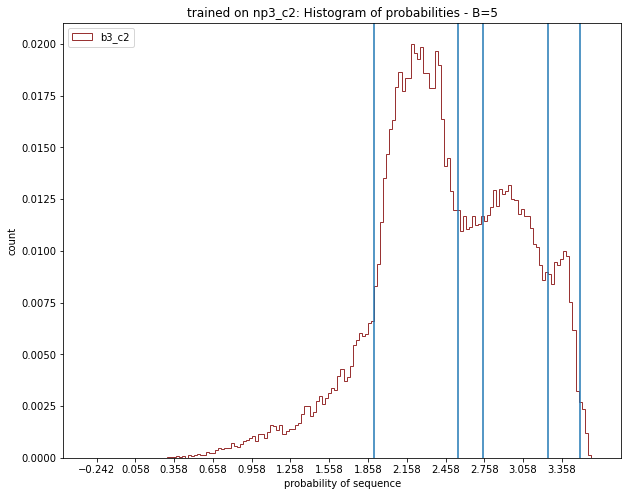

In [7]:
plt.figure(figsize=(10,8))
plt.hist(results_b3,alpha=0.8,bins=200,label="b3_c2", weights = weights_b3, color = "maroon", histtype='step');
#plt.hist(results_np1,alpha=0.6,bins=200,label="np1_c2", weights = weights_np1, color = "green", histtype='step');
#plt.hist(results_np3,alpha=0.5,bins=200,label="np3_c2", weights = weights_np3, color = "darkorange", histtype='step');
#plt.hist(results_r,alpha=0.7,bins=200,label="random data", weights = weights_rd, color="lightskyblue", histtype='step');
#plt.hist(results_t,alpha=0.5,bins=200,label="training data", weights = weights_t, color="grey", histtype='step');
#plt.hist(results_v,alpha=0.5,bins=200,label="validation data", weights = weights_v, color="red", histtype='step');

plt.xlabel("probability of sequence");
plt.ylabel("count")
plt.title("trained on np3_c2: Histogram of probabilities - B=5")
plt.legend();
plt.xticks(np.arange(min(results_b3), max(results_b3), 0.3));

plt.axvline(1.9,ymin=0, ymax=1)
plt.axvline(2.55,ymin=0, ymax=1)
plt.axvline(2.75,ymin=0, ymax=1)
plt.axvline(3.25,ymin=0, ymax=1)
plt.axvline(3.5,ymin=0, ymax=1)

plt.xlim(-0.5)

In [8]:
# PREPARING PAIRS OF SEQUENCE + PROBABILITY
#create dataloader again
seqs = m.fasta_read_pep(ds_b3_c2)
seq_, c = np.unique(seqs, return_counts=True, axis=0)
c_dict = dict(zip(seq_, c))
count_ = [c_dict[s] for s in seq_]
data = pd.DataFrame({'sequence': seq_, 'affinity': count_})
dictb3 = {}
for i in range(len(data)):
    dictb3[data.sequence[i]] = data.affinity[i]

b3_d = create_dataloader(dictb3)

# load and save sequences
seqs_b3 = []
for i, batch in enumerate(b3_d):
    seqs, ohe, labels = batch
    for i in seqs:
        seqs_b3.append(i)

In [9]:
p1_b3 = []
p2_b3 = []
p3_b3 = []
for i in range(len(results_b3)):
    if results_b3[i] > 1.9 and results_b3[i] < 2.55:
        p1_b3.append(seqs_b3[i])
    elif results_b3[i] > 2.75 and results_b3[i] < 3.25:
        p2_b3.append(seqs_b3[i])
    elif results_b3[i] > 3.26 and results_b3[i] < 3.5:
        p3_b3.append(seqs_b3[i])

In [32]:
ofile = open("p1_b3.fasta", "w")
for i in range(len(p1_b3)):
    ofile.write(">" + str(results_b3[i]) + "\n" + str(p1_b3[i]) + "\n")
ofile.close()

ofile = open("p2_b3.fasta", "w")
for i in range(len(p2_b3)):
    ofile.write(">" + str(results_b3[i]) + "\n" + str(p2_b3[i]) + "\n")
ofile.close()

ofile = open("p3_b3.fasta", "w")
for i in range(len(p3_b3)):
    ofile.write(">" + str(results_b3[i]) + "\n" + str(p3_b3[i]) + "\n")
ofile.close()

#### np1 analysis

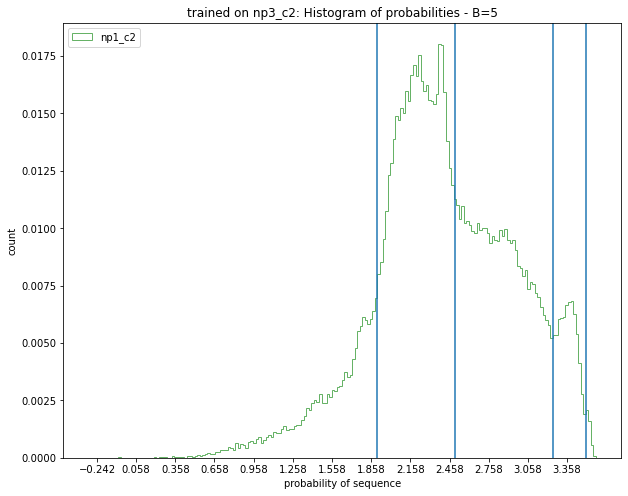

In [21]:
plt.figure(figsize=(10,8))
#plt.hist(results_b3,alpha=0.8,bins=200,label="b3_c2", weights = weights_b3, color = "maroon", histtype='step');
plt.hist(results_np1,alpha=0.6,bins=200,label="np1_c2", weights = weights_np1, color = "green", histtype='step');
#plt.hist(results_np3,alpha=0.5,bins=200,label="np3_c2", weights = weights_np3, color = "darkorange", histtype='step');
#plt.hist(results_r,alpha=0.7,bins=200,label="random data", weights = weights_rd, color="lightskyblue", histtype='step');
#plt.hist(results_t,alpha=0.5,bins=200,label="training data", weights = weights_t, color="grey", histtype='step');
#plt.hist(results_v,alpha=0.5,bins=200,label="validation data", weights = weights_v, color="red", histtype='step');

plt.xlabel("probability of sequence");
plt.ylabel("count")
plt.title("trained on np3_c2: Histogram of probabilities - B=5")
plt.legend();
plt.xticks(np.arange(min(results_b3), max(results_b3), 0.3));

plt.axvline(1.9,ymin=0, ymax=1)
plt.axvline(2.5,ymin=0, ymax=1)
plt.axvline(3.25,ymin=0, ymax=1)
plt.axvline(3.5,ymin=0, ymax=1)

plt.xlim(-0.5);

In [22]:
#PREPARING PAIRS OF SEQUENCE + PROBABILITY
#create dataloader again
seqs = m.fasta_read_pep(ds_np1_c2)
seq_, c = np.unique(seqs, return_counts=True, axis=0)
c_dict = dict(zip(seq_, c))
count_ = [c_dict[s] for s in seq_]
data = pd.DataFrame({'sequence': seq_, 'affinity': count_})
dictnp1 = {}
for i in range(len(data)):
    dictnp1[data.sequence[i]] = data.affinity[i]

np1_d = create_dataloader(dictnp1)

# load and save sequences
seqs_np1 = []
for i, batch in enumerate(np1_d):
    seqs, ohe, labels = batch
    for i in seqs:
        seqs_np1.append(i)

In [23]:
p1_np1 = []
p2_np1 = []
for i in range(len(results_np1)):
    if results_np1[i] > 1.9 and results_np1[i] < 2.5:
        p1_np1.append(seqs_np1[i])
    elif results_np1[i] > 3.25 and results_np1[i] < 3.5:
        p2_np1.append(seqs_np1[i])

In [56]:
ofile = open("p1_np1.fasta", "w")
for i in range(len(p1_np1)):
    ofile.write(">" + "  " + "\n" + str(p1_np1[i]) + "\n")
ofile.close()

ofile = open("p2_np1.fasta", "w")
for i in range(len(p2_np1)):
    ofile.write(">" + "  " + "\n" + str(p2_np1[i]) + "\n")
ofile.close()

#### Training data analysis

(1.2, 3.7638044503996464)

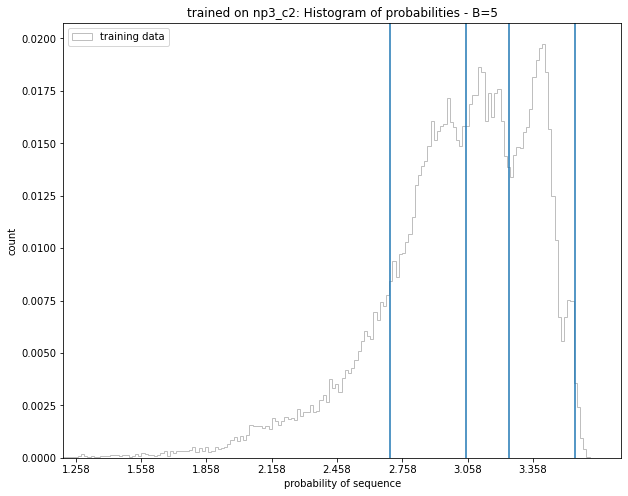

In [89]:
plt.figure(figsize=(10,8))
#plt.hist(results_b3,alpha=0.8,bins=200,label="b3_c2", weights = weights_b3, color = "maroon", histtype='step');
#plt.hist(results_np1,alpha=0.6,bins=200,label="np1_c2", weights = weights_np1, color = "green", histtype='step');
#plt.hist(results_np3,alpha=0.5,bins=200,label="np3_c2", weights = weights_np3, color = "darkorange", histtype='step');
#plt.hist(results_r,alpha=0.7,bins=200,label="random data", weights = weights_rd, color="lightskyblue", histtype='step');
plt.hist(results_t,alpha=0.5,bins=200,label="training data", weights = weights_t, color="grey", histtype='step');
#plt.hist(results_v,alpha=0.5,bins=200,label="validation data", weights = weights_v, color="red", histtype='step');

plt.xlabel("probability of sequence");
plt.ylabel("count")
plt.title("trained on np3_c2: Histogram of probabilities - B=5")
plt.legend();
plt.xticks(np.arange(min(results_b3), max(results_b3), 0.3));

plt.axvline(2.7,ymin=0, ymax=1)
plt.axvline(3.05,ymin=0, ymax=1)
plt.axvline(3.25,ymin=0, ymax=1)
plt.axvline(3.55,ymin=0, ymax=1)

plt.xlim(1.2)

In [78]:
#PREPARING PAIRS OF SEQUENCE + PROBABILITY
td = model.train_dataloader()

# load and save sequences
seqs_t = []
for i, batch in enumerate(td):
    seqs, ohe = batch
    for i in seqs:
        seqs_t.append(i)

In [82]:
p1_t = []
p2_t = []
p3_t = []
for i in range(len(results_t)):
    if results_t[i] > 2.7 and results_t[i] < 3.05:
        p1_t.append(seqs_t[i])
    elif results_t[i] > 3.06 and results_t[i] < 3.25:
        p2_t.append(seqs_t[i])
    elif results_t[i] > 3.26 and results_t[i] < 3.55:
        p3_t.append(seqs_t[i])

In [83]:
ofile = open("p1_t.fasta", "w")
for i in range(len(p1_t)):
    ofile.write(">" + "  " + "\n" + str(p1_t[i]) + "\n")
ofile.close()

ofile = open("p2_t.fasta", "w")
for i in range(len(p2_t)):
    ofile.write(">" + "  " + "\n" + str(p2_t[i]) + "\n")
ofile.close()

ofile = open("p3_t.fasta", "w")
for i in range(len(p3_t)):
    ofile.write(">" + "  " + "\n" + str(p3_t[i]) + "\n")
ofile.close()

#### Validation data analysis

(1.2, 3.7714249683389913)

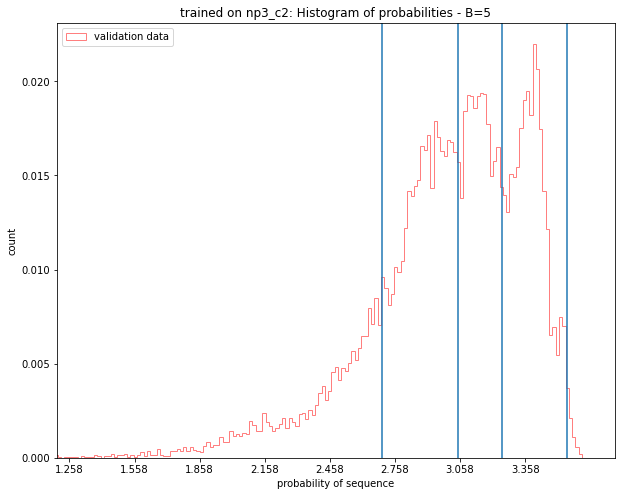

In [96]:
plt.figure(figsize=(10,8))
#plt.hist(results_b3,alpha=0.8,bins=200,label="b3_c2", weights = weights_b3, color = "maroon", histtype='step');
#plt.hist(results_np1,alpha=0.6,bins=200,label="np1_c2", weights = weights_np1, color = "green", histtype='step');
#plt.hist(results_np3,alpha=0.5,bins=200,label="np3_c2", weights = weights_np3, color = "darkorange", histtype='step');
#plt.hist(results_r,alpha=0.7,bins=200,label="random data", weights = weights_rd, color="lightskyblue", histtype='step');
#plt.hist(results_t,alpha=0.5,bins=200,label="training data", weights = weights_t, color="grey", histtype='step');
plt.hist(results_v,alpha=0.5,bins=200,label="validation data", weights = weights_v, color="red", histtype='step');

plt.xlabel("probability of sequence");
plt.ylabel("count")
plt.title("trained on np3_c2: Histogram of probabilities - B=5")
plt.legend();
plt.xticks(np.arange(min(results_b3), max(results_b3), 0.3));

plt.axvline(2.7,ymin=0, ymax=1)
plt.axvline(3.05,ymin=0, ymax=1)
plt.axvline(3.25,ymin=0, ymax=1)
plt.axvline(3.55,ymin=0, ymax=1)

plt.xlim(1.2)

In [100]:
#PREPARING PAIRS OF SEQUENCE + PROBABILITY
vd = model.val_dataloader()

# load and save sequences
seqs_v = []
for i, batch in enumerate(vd):
    seqs, ohe = batch
    for i in seqs:
        seqs_v.append(i)

In [101]:
p1_v = []
p2_v = []
p3_v = []
for i in range(len(results_v)):
    if results_v[i] > 2.7 and results_v[i] < 3.05:
        p1_v.append(seqs_v[i])
    elif results_v[i] > 3.06 and results_v[i] < 3.25:
        p2_v.append(seqs_v[i])
    elif results_v[i] > 3.26 and results_v[i] < 3.55:
        p3_v.append(seqs_v[i])

In [103]:
ofile = open("p1_v.fasta", "w")
for i in range(len(p1_v)):
    ofile.write(">" + "  " + "\n" + str(p1_v[i]) + "\n")
ofile.close()

ofile = open("p2_v.fasta", "w")
for i in range(len(p2_v)):
    ofile.write(">" + "  " + "\n" + str(p2_v[i]) + "\n")
ofile.close()

ofile = open("p3_v.fasta", "w")
for i in range(len(p3_v)):
    ofile.write(">" + "  " + "\n" + str(p3_v[i]) + "\n")
ofile.close()

## Saliency maps

In [10]:
import numpy as np
import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import copy
import os

def Sequence_logo(matrix, ax=None, data_type=None, figsize=None, ylabel=None, title=None, epsilon=1e-4, show=True, ticks_every=1, ticks_labels_size=14, title_size=20, molecule='protein'):
    if data_type is None:
        if matrix.min() >= 0:
            data_type = 'mean'
        else:
            data_type = 'weights'

    if data_type == 'mean':
        all_scores = build_scores(matrix, epsilon=epsilon)
    elif data_type == 'weights':
        all_scores = build_scores2(matrix)
    else:
        print('data type not understood')
        return -1

    if ax is not None:
        show = False
        return_fig = False
    else:
        if figsize is None:
            figsize = (max(int(0.5 * matrix.shape[0]), 2), 5)
        fig, ax = plt.subplots(figsize=figsize)
        return_fig = True

    x = 1
    maxi = 0
    mini = 0
    for scores in all_scores:
        if data_type == 'mean':
            y = 0
            for base, score in scores:
                if score > 0.01:
                    letterAt(base, x, y, score, ax, type=molecule)
                y += score
            x += 1
            maxi = max(maxi, y)


        elif data_type == 'weights':
            y_pos = 0
            y_neg = 0
            for base, score, sign in scores:
                if sign == '+':
                    letterAt(base, x, y_pos, score, ax)
                    y_pos += score
                else:
                    y_neg += score
                    letterAt(base, x, -y_neg, score, ax)
            x += 1
            maxi = max(y_pos, maxi)
            mini = min(-y_neg, mini)

    if data_type == 'weights':
        maxi = max(maxi, abs(mini))
        #mini = -maxi #change for our case
        mini = 0

    if ticks_every > 1:
        xticks = range(1, x)
        xtickslabels = ['%s' % k if k % ticks_every == 0 else '' for k in xticks]
        ax.set_xticks(xticks, xtickslabels)
    else:
        ax.set_xticks(range(1, x))
    ax.set_xlim((0, x))
    ax.set_ylim((mini, maxi))
    if ylabel is None:
        if data_type == 'mean':
            ylabel = 'Conservation (bits)'
        elif data_type == 'weights':
            ylabel = 'Weights'
    ax.set_ylabel(ylabel, fontsize=title_size)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='both', which='major', labelsize=ticks_labels_size)
    ax.tick_params(axis='both', which='minor', labelsize=ticks_labels_size)
    if title is not None:
        ax.set_title(title, fontsize=title_size)
    if return_fig:
        plt.tight_layout()
        if show:
            plt.show()
        return fig

#def letterAt(letter, x, y, yscale=1, ax=None, type='protein'):
#    if type == 'protein':
#        text = LETTERS[letter]
#    if type == 'dna':
#        text = LETTERSdna[aa_to_dna[letter]]
#    if type == 'rna':
#        text = LETTERSrna[aa_to_rna[letter]]
#    t = mpl.transforms.Affine2D().scale(1 * globscale, yscale * globscale) + \
#        mpl.transforms.Affine2D().translate(x, y) + ax.transData
#    p = PathPatch(text, lw=0, fc=COLOR_SCHEME[letter], transform=t)
#    if ax != None:
#        ax.add_artist(p)
#    return p

def letterAt(letter, x, y, yscale=1, ax=None):
    text = LETTERS[letter]

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=COLOR_SCHEME[letter],  transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

def aa_color(letter):
    if letter in ['C']:
        return 'green'
    elif letter in ['F', 'W', 'Y']:
        return [199 / 256., 182 / 256., 0., 1.]  # 'gold'
    elif letter in ['Q', 'N', 'S', 'T']:
        return 'purple'
    elif letter in ['V', 'L', 'I', 'M']:
        return 'black'
    elif letter in ['K', 'R', 'H']:
        return 'blue'
    elif letter in ['D', 'E']:
        return 'red'
    elif letter in ['A', 'P', 'G']:
        return 'grey'
    elif letter in ['$\\boxminus$']:
        return 'black'
    else:
        return 'black'

def build_scores(matrix,epsilon = 1e-4):
    n_sites = matrix.shape[0]
    n_colors = matrix.shape[1]
    all_scores = []
    for site in range(n_sites):
        conservation = np.log2(21) + (np.log2(matrix[site]+epsilon) * matrix[site]).sum()
        liste = []
        order_colors = np.argsort(matrix[site])
        for c in order_colors:
            liste.append( (list_aa[c],matrix[site,c] * conservation) )
        all_scores.append(liste)
    return all_scores


def build_scores2(matrix):
    n_sites = matrix.shape[0]
    n_colors = matrix.shape[1]
    epsilon = 1e-4
    all_scores = []
    for sitewtf in range(n_sites): #WTF
        liste = []
        c_pos = np.nonzero(matrix[sitewtf] >= 0)[0]
        c_neg = np.nonzero(matrix[sitewtf] < 0)[0]

        order_colors_pos = c_pos[np.argsort(matrix[sitewtf][c_pos])]
        order_colors_neg = c_neg[np.argsort(-matrix[sitewtf][c_neg])]
        for c in order_colors_pos:
            liste.append( (list_aa[c],matrix[sitewtf,c],'+') )
        for c in order_colors_neg:
            liste.append( (list_aa[c],-matrix[sitewtf,c],'-') )
        all_scores.append(liste)
    return all_scores

dna = ['A', 'C', 'G', 'T', '$\\boxminus$']
rna = ['A', 'C', 'G', 'U', '$\\boxminus$']
list_aa = ['A', 'R', 'N', 'D', 'C', 'E', 'Q','G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', '-'] #change i guess???


fp = FontProperties(family="Arial", weight="bold")
LETTERS = dict([(letter, mpl.textpath.TextPath((-0.30, 0), letter, size=1, prop=fp)) for letter in list_aa])
LETTERSdna = dict([(letter, mpl.textpath.TextPath((-0.30, 0), letter, size=1, prop=fp)) for letter in dna])
LETTERSrna = dict([(letter, mpl.textpath.TextPath((-0.30, 0), letter, size=1, prop=fp)) for letter in rna])
COLOR_SCHEME = dict([(letter, aa_color(letter)) for letter in list_aa])
globscale = 1.35

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


In [17]:
def saliency_map(self, data_loader):
    saliency_maps = []
    for i, batch in enumerate(data_loader):
        seqs, ohe, labels = batch
        one_hot_v = Variable(ohe.double(), requires_grad=True)
        # get output from the model, given the inputs
        [recon_x, inputs, mu, log_var, encode_attn_maps, decode_attn_maps] = self(one_hot_v)

        loss_dict = self.loss_function(recon_x, ohe, mu, log_var)
        loss = loss_dict["loss"]
        
        loss.backward()

        saliency_maps.append(one_hot_v.grad.data.detach().abs())
    return torch.cat(saliency_maps, dim=0)
    
def process_peak(peak_data,titl):
    di = {}
    for i in peak_data:
        di[str(i[0])]=0

    pp_d = create_dataloader(di)
    salmapres = saliency_map(model,pp_d)

    #reshape positions
    aseq = []
    for i in range(len(salmapres)):
        oseq = []
        for pos in range(len(salmapres[0][0][0])):
            ps = []
            for ak in range(len(salmapres[0][0])): 
                ps.append(float(salmapres[i][0][ak][pos]))
            oseq.append(ps)
        oseq = pd.DataFrame(oseq)
        aseq.append(oseq)

    #px = px.to_numpy()

    avgDataFrame = aseq[0]

    for i in range(1, len(aseq)):
        avgDataFrame = avgDataFrame.add(aseq[i])

    avgDataFrame = avgDataFrame / len(aseq)

    px = avgDataFrame.to_numpy()

    Sequence_logo(px, data_type= "weights", title=titl)
    




### b3 peaks saliency maps

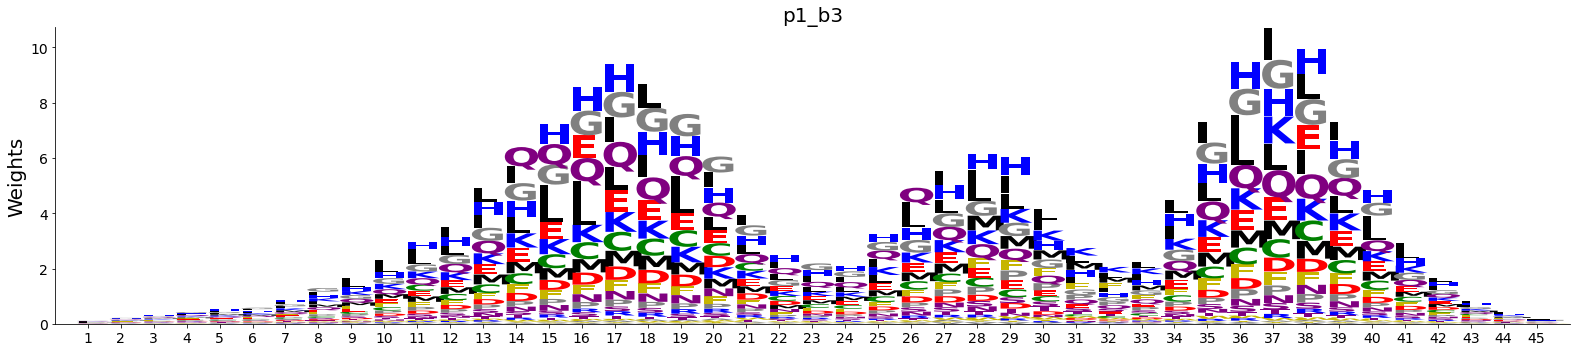

In [20]:
process_peak(p1_b3, "p1_b3")

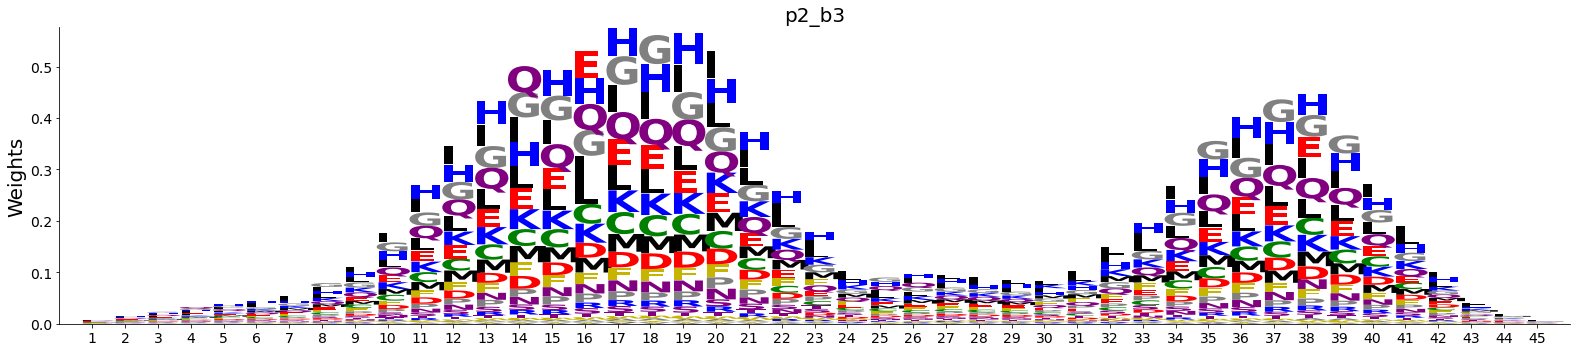

In [19]:
process_peak(p2_b3, "p2_b3")

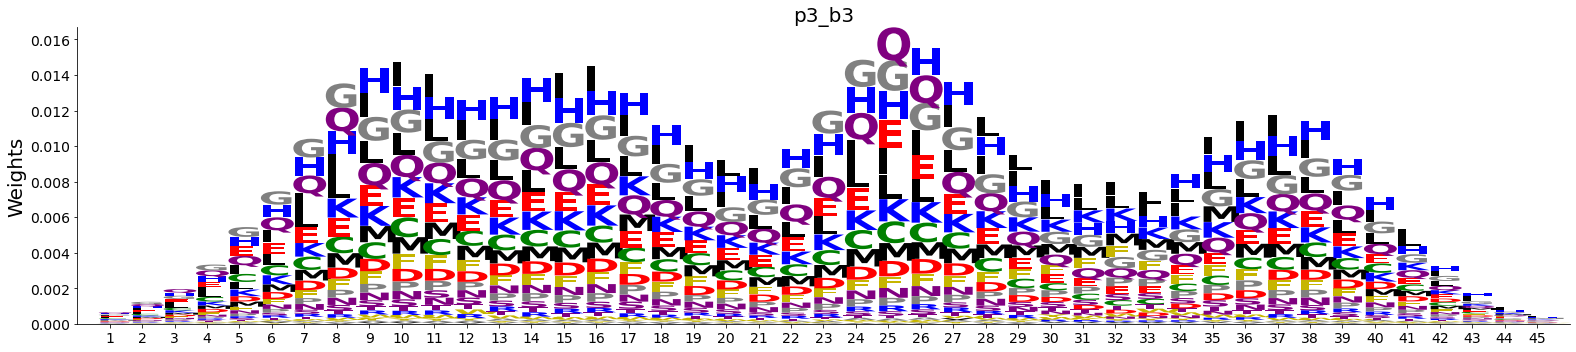

In [18]:
process_peak(p3_b3,"p3_b3")

### np1 peaks saliency maps

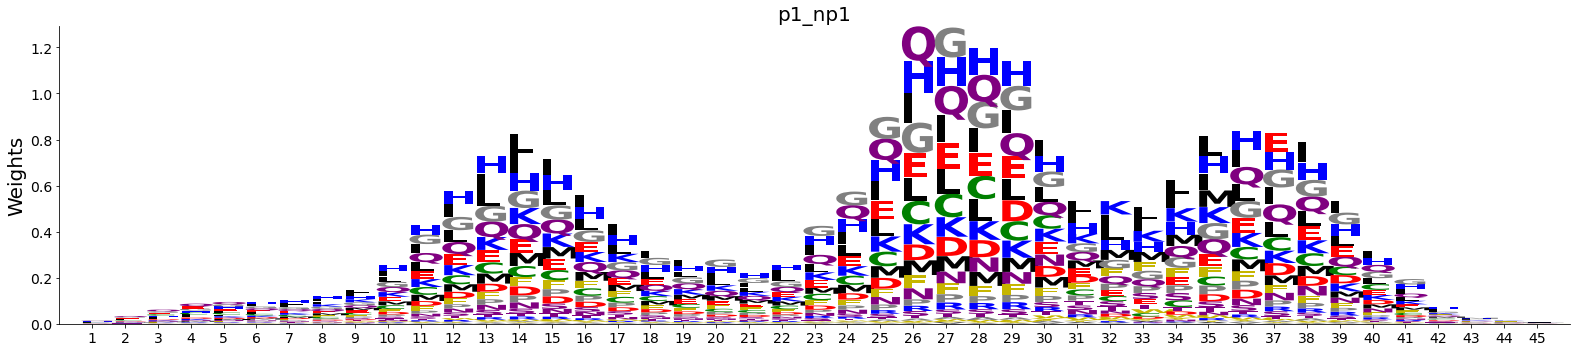

In [24]:
process_peak(p1_np1, "p1_np1")

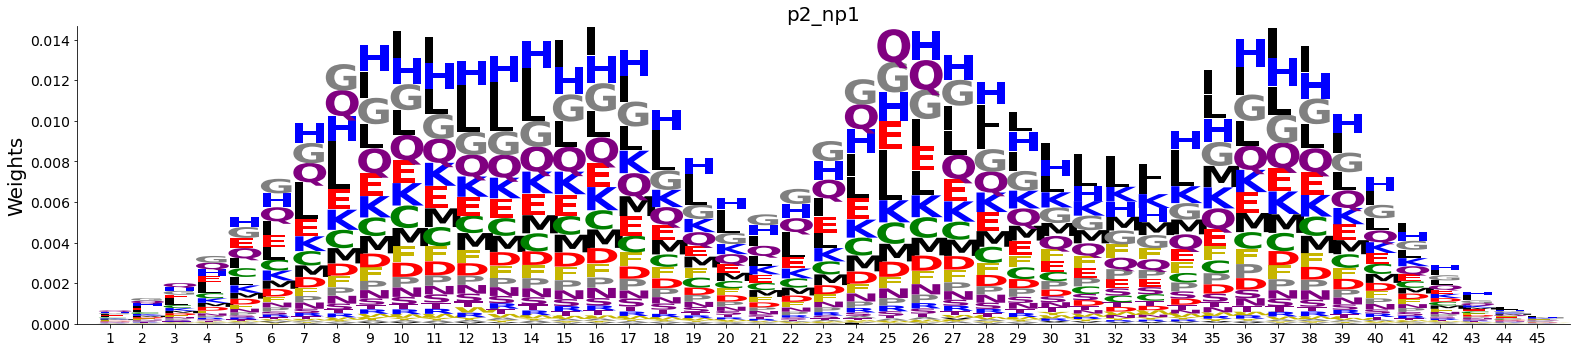

In [25]:
process_peak(p2_np1, "p2_np1")